In [1]:
knitr::opts_chunk$set(echo = FALSE)
suppressMessages(expr =  {
  if ("xfun" %in% row.names(installed.packages()) == FALSE) {
    install.packages("xfun")
  }

  if ("IRdisplay" %in% row.names(installed.packages()) == TRUE) {
    display_markdown <<- \(x) IRdisplay::display_markdown(as.character(x))
    display_html <<- \(x) IRdisplay::display_html(as.character(x))
  } else {
    display_markdown <<- knitr::asis_output
    display_html <<- knitr::asis_output
  }

xfun::pkg_attach(
    c("tidyverse",
      "polspline",
      "patchwork",
      "magrittr",
      "bayesplay",
      "knitr",
      "bayesplay"),
      install = TRUE)

})

table_format <- "html"


# An alternative to *p* values

Coming up with an alternative to *p* values requires us to rearrange our
thinking a bit. So let's first get straight what we're doing with frequentist
inference. In frequentist inference we set some parameter to a certain value
($\theta$), we then generate data from imaginary experiments using that
parameter setting, and we then compare our data to the data from those
experiments. We then ask the question: "Given that parameter value, how
surprising is our data?" At no point are we making inferences *about the value*
of $\theta$. We **set** the value, and we ask a question about our data in
relation to **all the possible data** that might be generated.

To think about what an alternative might look like, let us think back to our
earlier example on the different meanings of probability. With *p*-values we
thought about probability in terms of relative frequency. We were asking "how
often?" questions. But I also mentioned another example. The example of being
90% sure that the accused committed a crime. If we want to be rational humans,
when we make claims like this what we usually do is examine the evidence. We
**compare** whether there is more evidence for the accused's guilt or the
accused's innocence. That is, we take the courtroom evidence and examine
whether it supports hypothesis 1 (the accused is guilty) or hypothesis 2 (the
accused is innocent). To do this we balance of probabilities. Is is more
probable that we'd see this evidence if hypothesis 1 was true, or is it more
probable that we'd see this evidence if hypothesis 2 was true? (In a civil
trial we'd just weigh up the probabilities, but in a criminal trial we'd have
to also examine whether this difference in probabilities exceeds some
threshold. We'll leave this issue of thresholds for now). Might we be able to
apply the same kind of thinking to statistical evidence?

To understand the concept of statistical evidence, let's go back to our coin
flipping example. In our coin flipping example, we collected 10 flips and found
8 heads and 2 tails. Our frequentist analysis asked something like, "is this
data surprising?". But we could ask another question. That question might go
something like this: "Is it more likely that the **bias is 0.6** or that the
**bias is 0.8** given that we'd obtained 8 heads in 10 flips?"

To try and answer this question, we'll again create some simulations. We'll
start by creating two **sampling distributions**. For now we'll keep things
simple and we'll create these sampling distributions on the assumption that I
intended to flip the coin 10 times. To create our sampling distributions we'll
first set $\theta$ to 0.6 and run the simulations, and then we'll set $\theta$
to 0.8 and run the simulations. I know the distribution they'll follow, so I'll
just compute the distributions directly rather than actually running the
simulations.

In [2]:
# flip the coin n times and then count up the heads.
# three parameters need to be set
# 1. the number of flips (n_flips)
# 2. the probability of heads (pr_heads)
# 3. the number of heads in our observation (obs_heads)

coin_flip_v1 <- function(n_flips, pr_heads, obs_heads) {
  pmap_df(
    tibble(heads = 0:n_flips, flips = n_flips, pr_heads = pr_heads),
    function(heads, flips, pr_heads) {
      tibble(
        flips = flips, heads = heads,
        freq = dbinom(heads, flips, pr_heads)
      )
    }
  ) %>% # get the frequency
    mutate(our_ob = case_when(
      flips == n_flips & heads == obs_heads ~ TRUE,
      TRUE ~ FALSE
    )) # mark our observation
}

We can draw the distributions of the possible data that would occur for
different values of P(heads) = $\theta$. In each of the plots, our
actual observation will be highlighted. Although we're "simulating" all
possible observations, you'll see that we're only going to care about our
**actual** observation. We will want to know the relative frequency with which
**that** result occurs, not the frequency of results that didn't but might've
occurred. I'm going to draw several distributions not just two that correspond
to the values of $\theta$ that we're interested in.

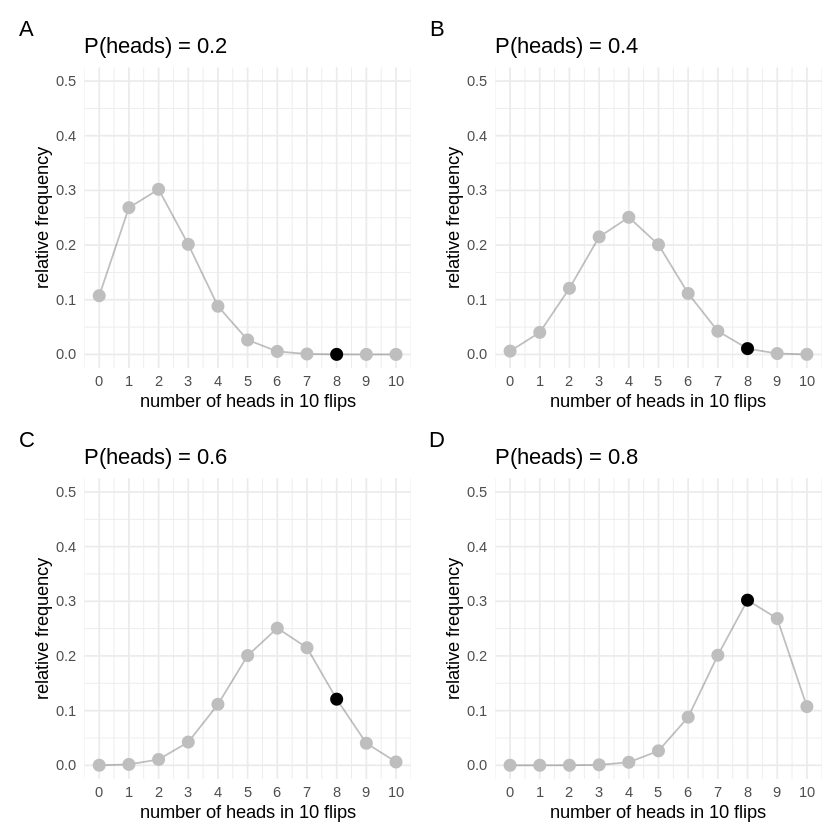

In [3]:
# draw distributions of the data for various values of pr_heads for version 1
# (flip n times)

n_flips <- 10

pr_heads_values <- c(0.2, 0.4, 0.6, 0.8) # set our pr_heads values

obs_heads <- 8

# make the plots
coin_flip_v1_plots <- pmap(
  tibble(n_flips = n_flips, pr_heads = pr_heads_values, obs_heads = obs_heads),
  function(n_flips, pr_heads, obs_heads) {
    coin_flip_v1(n_flips, pr_heads, obs_heads) %>%
      ggplot(aes(x = heads, y = freq)) +
      geom_line(alpha = .25) +
      geom_point(aes(colour = our_ob), size = 3) +
      scale_colour_manual(
        guide = "none",
        values = c("TRUE" = "black", "FALSE" = "grey")
      ) +
      labs(
        x = glue::glue("number of heads in {n_flips} flips"),
        y = "relative frequency",
        title = glue::glue("P(heads) = {pr_heads}")
      ) +
      scale_x_continuous(breaks = c(seq(0, n_flips, 1))) +
      scale_y_continuous(limits = c(0, .5)) +
      theme_minimal() +
      NULL
  }
)

# make the plots pretty and arrange them

(wrap_plots(coin_flip_v1_plots, nrow = 2) +
  plot_annotation(tag_levels = "A"))

Let's take these plots and create a new one out of them. Since we're just
interested in **our specific observation** we'll take all the marked points and
put them on a plot of their own. Now we'll still have relative frequency on the
y-axis, but on the x-axis we won't have the observation anymore (because we're
only focused on one specific outcome). Instead, we'll have $\theta$ on the
x-axis.

In [4]:
# first set our observation again
number_of_heads <- 8
number_of_flips <- 10

# and set the range of bias to consider
pr_heads_range <- seq(0, 1, .1) # 0/10, 1/10 ... 9/10, 10/10

# translate our observation into the parameters needed for version 1
# generate the data and pull out the relative frequency of our specific
# observation

n_flips <- number_of_flips
obs_heads <- number_of_heads
likelihood_v1 <- map_df(pr_heads_range, function(x) {
  coin_flip_v1(n_flips, x, obs_heads) %>%
    filter(our_ob == TRUE) %>%
    select(freq) %>%
    mutate(pr_heads = x)
})

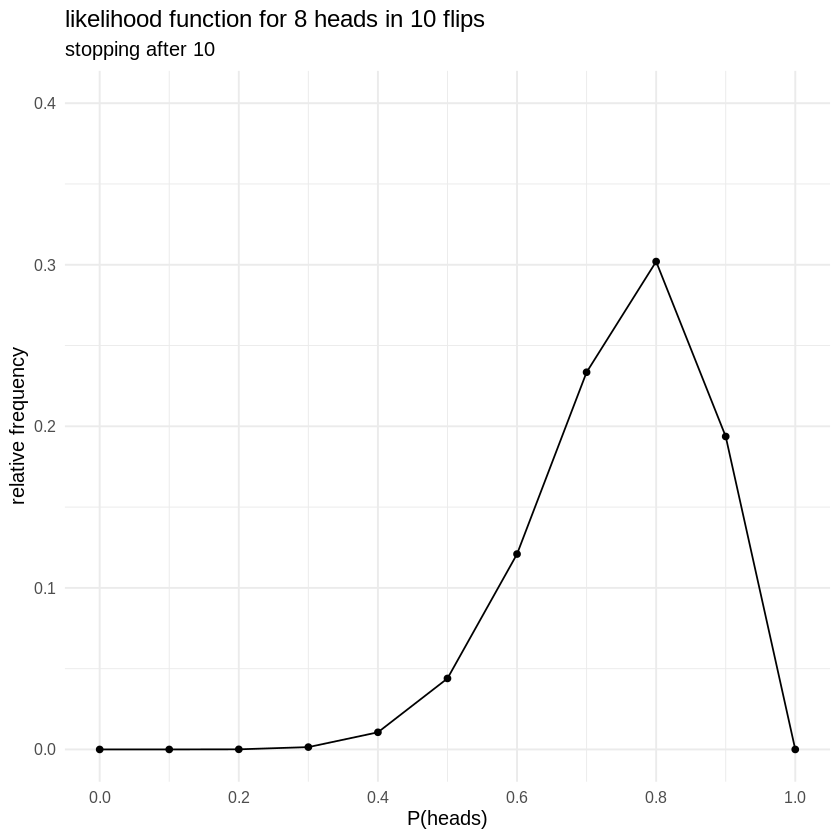

In [5]:
# now actually draw the plot

likelihood_v1 %>%
  ggplot(aes(x = pr_heads, y = freq)) +
  geom_point() +
  geom_line() +
  theme_minimal(12) +
  scale_x_continuous(name = "P(heads)", breaks = seq(0, 1, .2)) +
  scale_y_continuous(limits = c(0, .4), name = "relative frequency") +
  labs(
    title = glue::glue(
      "likelihood function for {number_of_heads}",
      " heads in {number_of_flips} flips"
    ),
    subtitle = glue::glue("stopping after {number_of_flips}")
  )

This new plot that we're created illustrates what's know as the **likelihood**
function. The likelihood function describes the relationship between values of
the parameter and **our data**. It's made up of slices of the sampling
distribution-the slices that correspond to our actual observation. Remember
that when we were doing inference with the sampling distribution we were
looking at the extreme tails of the sampling distribution. That is, we were
interested in the entire shape of the sampling distribution. Now we're instead
only interested in the thin slice that corresponds to our observation.

## Doing inference with likelihoods

The likelihood plays a key role in Bayesian inference. Inferences on the basis
of likelihoods are derived from what is known at the *law of likelihood*.
Simply stated, the *law of likelihood* says that for a given pair of
hypotheses---for example, $\mathcal{H}_1$ that the coin bias is P(heads)=0.6
and $\mathcal{H}_2$ that the coin bias is P(heads)=0.8---then data support
$\mathcal{H}_1$ over $\mathcal{H}_2$ if the likelihood of $\mathcal{H}_1$
exceeds that of $\mathcal{H}_2$. Or, put another way, if our data would be
produced more often if $\mathcal{H}_1$ were true than if $\mathcal{H}_2$ were
true, then the data provide support for $\mathcal{H}_1$ over $\mathcal{H}_2$
(See [Hacking,
1965](https://www.google.co.uk/books/edition/Logic_of_Statistical_Inference/cEJfDAAAQBAJ?hl=en&gbpv=0) Chapter 5, for both formulations).

This definition might seem a little opaque, but we can read these likelihood
values straight off our likelihood plot. The height of the likelihood plot, at
each value of $\theta$, tells you the probability of obtaining your data given
that value of $\theta$. If the likelihood function is higher at $\theta=0.8$
than $\theta=0.6$ then the probability of obtaining our data would be higher if
$\theta$ was 0.8 than it would be if $\theta$ was 0.6. Consequently, our data
support the hypothesis that $\theta=0.8$ *over* the hypothesis $\theta=0.6$. A
key point here, that's worth stressing, is that this is a comparison between
two specific hypothesis. Does this data support this one specific hypothesis
over this other specific hypothesis. What you're doing here is *weighing up
probabilities* just like you would do in a courtroom.

### A brief detour back to sampling rules

Before we continue, let's just go back to something from the previous section.
I made a big deal about how our sampling rules change the shape of the sampling
distribution, and that this then changes the inferences that we make. This is
the case even if nothing changes about our actual data. But do different
sampling rules change the likelihood? To test this out, we'll generate a new
set of sampling distributions using the other sampling rule (sampling until we
get 2 heads). And from these sampling distributions we'll generate some
likelihoods.

In [6]:
# function v2 "simulates" results from the version where you
# flip the coin until it comes up tails n times.
# three parameters need to be set
# 1. the number of tails to stop at (n_tails)
# 2. the probability of heads (pr_heads)
# 3. the number of flips in our observation (obs_flips)

coin_flip_v2 <- function(n_tails, pr_heads, obs_flips) {
  pmap_df(
    tibble(
      tails = n_tails,
      pr_heads = pr_heads,
      flips = 0:(obs_flips + 4)
    ), # input values
    function(tails, pr_heads, flips) {
      tibble(
        flips = flips, tails = tails,
        freq = dnbinom(flips - tails, tails, 1 - pr_heads)
      )
    }
  ) %>%
    mutate(our_ob = case_when(
      flips == obs_flips & tails == tails ~ TRUE,
      TRUE ~ FALSE
    )) # mark our observation
}

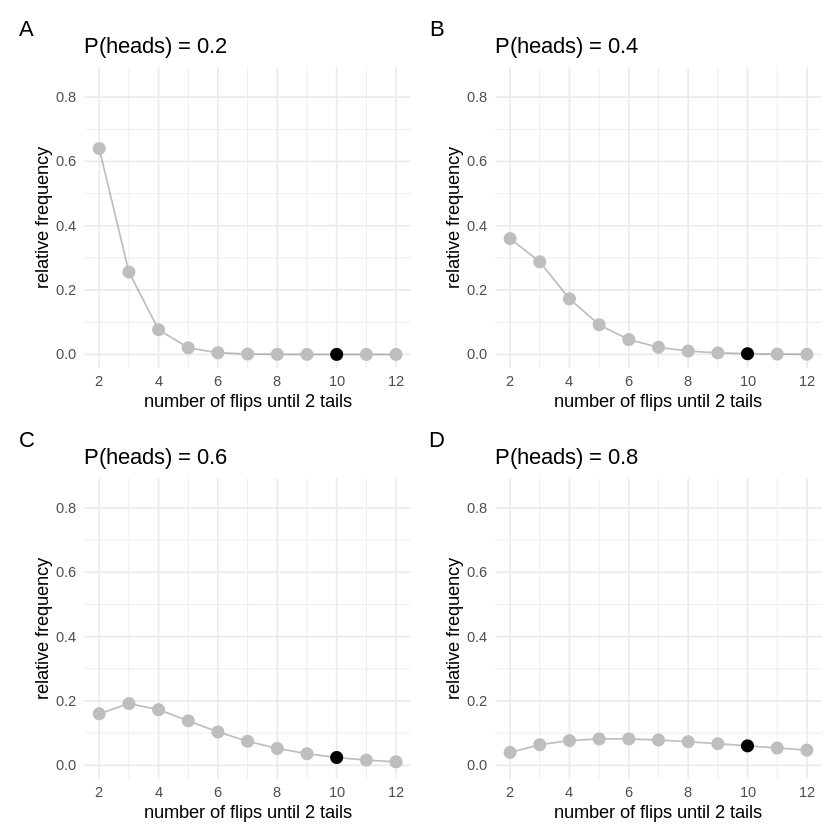

In [7]:
# draw distributions of the data for various values of pr_heads for version 2
# (flip until n tails)

n_tails <- 2
n_flips <- 10
pr_heads_values <- c(0.2, 0.4, 0.6, 0.8) # set our pr_heads
obs_flips <- 10
# make the plots
coin_flip_v2_plots <- pmap(
  tibble(n_tails = n_tails, pr_heads = pr_heads_values, obs_flips = obs_flips),
  function(n_tails, pr_heads, obs_flips) {
    coin_flip_v2(n_tails, pr_heads, obs_flips) %>%
      ggplot(aes(x = flips, y = freq)) +
      geom_line(alpha = .25, na.rm = TRUE) +
      geom_point(aes(colour = our_ob), size = 3, na.rm = TRUE) +
      scale_colour_manual(
        guide = "none",
        values = c("TRUE" = "black", "FALSE" = "grey")
      ) +
      labs(
        x = glue::glue("number of flips until {n_tails} tails"),
        y = "relative frequency",
        title = glue::glue("P(heads) = {pr_heads}")
      ) +
      scale_x_continuous(breaks = seq(2, 12, 2), limits = c(2, 12)) +
      scale_y_continuous(limits = c(0, .85)) +
      theme_minimal() +
      NULL
  }
)


(wrap_plots(coin_flip_v2_plots, nrow = 2) +
  plot_annotation(tag_levels = "A"))

We can see that these sampling distributions look very different to the
sampling distributions that we generated above. But what we're interested in
are just the highlighted points, because we'll use these to generate our
likelihood.

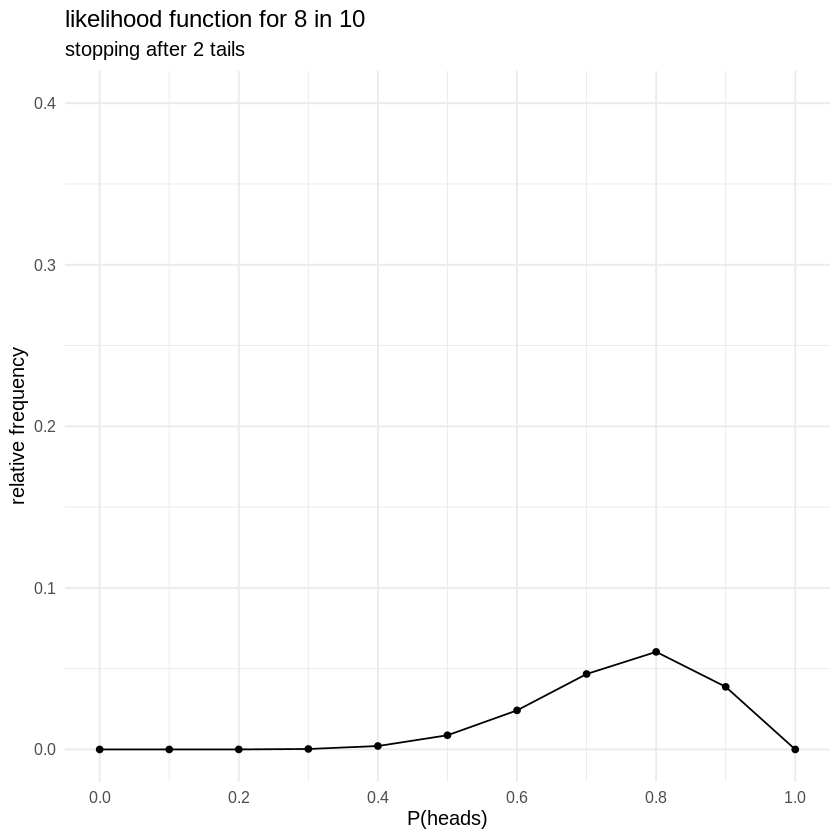

In [8]:
# translate our observation into the parameters needed for version 2
# generate the data and out the relative frequency of our specific observation
n_tails <- number_of_flips - number_of_heads
obs_flips <- number_of_flips
likelihood_v2 <- map_df(pr_heads_range, function(x) {
  suppressWarnings({ # supress warnings about impossible values
    coin_flip_v2(n_tails, x, obs_flips) %>%
      filter(our_ob == TRUE) %>%
      select(freq) %>%
      mutate(pr_heads = x) %>%
      mutate(freq = ifelse(is.na(freq), 0, freq))
  })
}) # replace NaN (impossible values) with 0 for plotting

# now actually draw the plot

likelihood_v2 %>%
  ggplot(aes(x = pr_heads, y = freq)) +
  geom_point() +
  geom_line() +
  theme_minimal(12) +
  scale_x_continuous(name = "P(heads)", breaks = seq(0, 1, .2)) +
  scale_y_continuous(limits = c(0, .4), name = "relative frequency") +
  labs(
    title = glue::glue(
      "likelihood function for {number_of_heads} ",
      "in {number_of_flips}"
    ),
    subtitle = glue::glue("stopping after {n_tails} tails")
  )

The new likelihood might, at first glance, look different to the one we
generated earlier, but it's just a scaled version of the earlier likelihood. We
can check this just by rescaling the two likelihoods so that they both have a
max of 1.

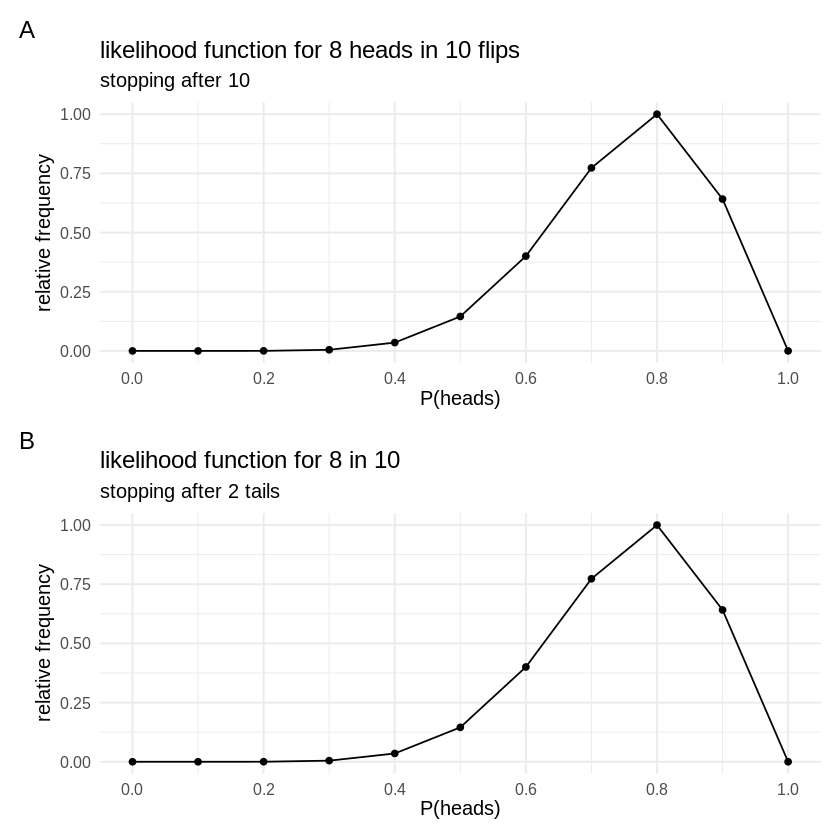

In [9]:
# now draw scaled versions of the plots

likelihood_v1_plot <- likelihood_v1 %>%
  mutate(freq = freq / max(freq)) %>%
  ggplot(aes(x = pr_heads, y = freq)) +
  geom_point() +
  geom_line() +
  theme_minimal(12) +
  scale_x_continuous(name = "P(heads)", breaks = seq(0, 1, .2)) +
  scale_y_continuous(limits = c(0, 1), name = "relative frequency") +
  labs(
    title = glue::glue(
      "likelihood function for {number_of_heads} ",
      "heads in {number_of_flips} flips"
    ),
    subtitle = glue::glue("stopping after {number_of_flips}")
  )

likelihood_v2_plot <- likelihood_v2 %>%
  mutate(freq = freq / max(freq)) %>%
  ggplot(aes(x = pr_heads, y = freq)) +
  geom_point() +
  geom_line() +
  theme_minimal(12) +
  scale_x_continuous(name = "P(heads)", breaks = seq(0, 1, .2)) +
  scale_y_continuous(limits = c(0, 1), name = "relative frequency") +
  labs(
    title = glue::glue(
      "likelihood function for {number_of_heads} ",
      "in {number_of_flips}"
    ),
    subtitle = glue::glue("stopping after {n_tails} tails")
  )


(likelihood_v1_plot / likelihood_v2_plot +
  plot_annotation(tag_levels = "A"))

Now that they're been rescaled we can see that they're they same. Note that
scaling changes the absolute distance between points on the likelihood, but it
doesn't change the *relative* distance between the points. When we want to know
the difference between two likelihood values we take the *ratio* of these two
values. The ratio gives us the *relative distance* between the heights on the
likelihood function, and the *relative distance* doesn't change with scaling.

More importantly, however, what this demonstrates is that when we do inference
with **likelihoods** instead of **sampling distributions**, things like
stopping rules, data that wasn't collected but might have been collected, and
all those other sorts of things that were tricky about *p*-values don't come in
to play. We only have the worry about **the data we actually have**, and the
**likelihood** which relates **parameter values** to **data**.

### The likelihood ratio

The likelihood ratio is going to be our measure of evidence of how much
the data supports one hypothesis over another. If the likelihood at point
one ($\theta_1$) is four times the larger than the likelihood at point two
($\theta_2$) then the data are four times more likely under the hypothesis
$\theta = \theta_1$ than the hypothesis $\theta = \theta_2$. Or simply
put, the data supports the hypothesis $\theta=\theta_1$  over
$\theta=\theta_2$ but a factor of 4 to 1.

Let's look at the likelihood for our actual data and our two hypotheses
about the coin bias. Just to drive home the point that the sampling rule
doesn't matter, I'm going to work out the likelihood ratio for the
sampling rule where I flip the coin 10 times and the sampling rule where
I flip the coin until I get 2 heads and just happen to flip it 10 times.
We'll see that the absolute values of the likelihoods change (as we saw in
the plots above), but that the likelihood ratio between the hypotheses
don't change. 

To make sure that the numbers work out correctly, I won't use simulations
to generate the likelihoods. Instead I'll just generate each likelihood
with the relevant formula. 

In [10]:
# define a function for nice printing
print_likelihood <- function(h1, h2, likelihood_1, likelihood_2) {
  likelihood_1_text <- glue::glue(
    "The likelihood for $\\mathcal{{H}}_1$ (P(heads) = {h1}) ",
    "is {round(likelihood_1,2)}"
  )
  likelihood_2_text <- glue::glue(
    "The likelihood for $\\mathcal{{H}}_2$ (P(heads) = {h2}) ",
    "is {round(likelihood_2,2)}"
  )
  ratio_text <- glue::glue(
    "The likelihood ratio is {round(likelihood_1 / likelihood_2, 2)}"
  )
  interpretation <- glue::glue(
    "The data are {round(likelihood_1 / likelihood_2, 2)} times more ",
    "probable under $\\mathcal{{H}}_1$ than $\\mathcal{{H}}_2$"
  )
  paste(c(likelihood_1_text, likelihood_2_text, ratio_text, interpretation),
    collapse = "\n\n"
  )
}

First, for version 1, where I flip the coin 10 times (**binomial**
sampling rule).

In [11]:
# set out observation
n <- 10 # number of flips
h <- 8 # number of heads
t <- n - h # number of tails

# set our two hypotheses
h1 <- 0.6 # the probability of getting heads is 0.6
h2 <- 0.8 # the probability of getting heads is 0.8

# work out the likelihood values
likelihood_1 <- dbinom(h, n, h1)
likelihood_2 <- dbinom(h, n, h2)

print_likelihood(h1, h2, likelihood_1, likelihood_2) %>% display_markdown()

The likelihood for $\mathcal{H}_1$ (P(heads) = 0.6) is 0.12

The likelihood for $\mathcal{H}_2$ (P(heads) = 0.8) is 0.3

The likelihood ratio is 0.4

The data are 0.4 times more probable under $\mathcal{H}_1$ than $\mathcal{H}_2$

Second, for version 2, where I flip the coin until I get 2 hears
(**negative-binomial** sampling rule).

In [12]:
# Set our observation
n <- 10 # number of flips
h <- 8 # number of heads
t <- n - h # number of tails

# set our two hypotheses
h1 <- 0.6 # the probability of getting heads is 0.6
h2 <- 0.8 # the probability of getting heads is 0.8

# work out the likelihood values
likelihood_1 <- dnbinom(t, h, h1)
likelihood_2 <- dnbinom(t, h, h2)

print_likelihood(h1, h2, likelihood_1, likelihood_2) %>% display_markdown()

The likelihood for $\mathcal{H}_1$ (P(heads) = 0.6) is 0.1

The likelihood for $\mathcal{H}_2$ (P(heads) = 0.8) is 0.24

The likelihood ratio is 0.4

The data are 0.4 times more probable under $\mathcal{H}_1$ than $\mathcal{H}_2$

### A note about likelihood functions and probability distributions

One common misconception about likelihood functions is that they're
probability distributions. This misconception can come in a few different
forms, so it's worth just stressing again what a likelihood function is. 

First, we can tell a likelihood function isn't a probability distribution,
because for a probability distribution the area under the curve would have
to sum to 1. Each point on a probability distribution gives the probability
of a specific event. The whole curve describes all the events that could
happen, and the area under the curve gives the probability that one of the
possible events happens. That is, it is the sum of all the individual
probabilities of the different events.

In the plot below, we can see the likelihood functions for different
events (different numbers of heads in 10 flips). We can see that the area
under the curve varies in each case. If these were probability
distributions then the area under the curve in each case would be 1.

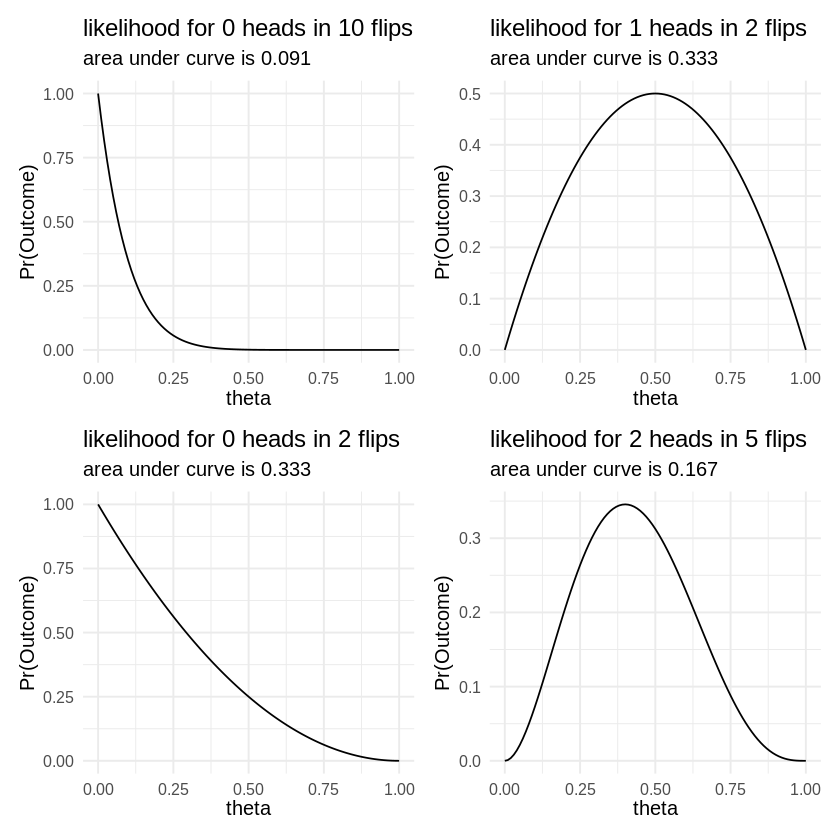

In [13]:
# plot some likelihood functions

scenarios <- list(
  p1 = list(heads = 0, flips = 10),
  p2 = list(heads = 1, flips = 2),
  p3 = list(heads = 0, flips = 2),
  p4 = list(heads = 2, flips = 5)
)

plots <- map(scenarios, function(x) {
  data_model <- bayesplay::likelihood("binomial",
    successes = x$heads,
    trials = x$flips
  )
  auc <- integrate(data_model$likelihood_function, 0, 1)$value
  plot(data_model) +
    labs(
      title = glue::glue("likelihood for {x$heads} heads in {x$flips} flips"),
      subtitle = glue::glue("area under curve is {round(auc,3)}")
    ) +
    theme_minimal(12) +
    NULL
})

wrap_plots(plots)

This misconception about likelihood functions being probability
distribution often takes the form of thinking that the likelihood function
tells use the probability of the parameter being a specific value. That
is, it tells us that there's a higher probability that $\theta=\theta_1$
than $\theta=\theta_2$, given our data. Put another way, this
misconception states that the likelihood tells us $p(\theta|y)$. This
quantity, however, is what's know as the **posterior probability**.
Rather, the likelihood tells us the reserve conditional, or $p(y|\theta)$.
That is, it tells use the probability of obtaining our data given
different values of the parameter.

To emphasise that the likelihood is not a probability distribution it is
often denoted $\mathcal{L}(\theta|y)$.

## Testing more complex hypotheses

So we've seen that comparing likelihoods (by taking their ratio) can tell
us which hypothesis is better supported by the data. However, there's
a couple of problems with what we've done up until now. First, how do we
know explicitly set a threshold for when we would start digging for
treasure. Is there also a threshold for likelihood ratios? To answer this
question, we're going to have to take into account a lot of additional
factors. And the answer to this question is probably going to be
context-dependent. For example, if we're placing bets on hypotheses, we're
probably going to want to take into account the relative pay-offs. If
we're using evidence to decide somebody's guilt in a court case, we're
probably going to want to take into account things like "reasonable
doubt". In short, there's not a straight forward answer to this question,
so we'll set it aside for now. Instead, we'll turn to the second problem.

The second problem with what we've done up until now is that we've just
been comparing single point hypothesis. We can can say, for example,
whether the data supports P(heads) = 0.5 over the hypothesis P(heads)
= 0.8, and we can quantify this level of support. But usually, we are not
comparing two simple hypotheses like this. Our hypotheses take a more
complex form like: "Is the coin fair?"

How might we go about answering this question?

To come up with a way to answer this question we're going to think about
hypotheses in terms of **predictions**. Our first hypothesis,
$\mathcal{H}_0$, will be that the coin is fair. And we'll say a fair coin
has a bias of 0.5. What do we predict will happen if we flip the coins 10
times? Most of the time it'll show around about 5 heads and 5 tails, but
it will also rarely show 1 head and 9 heads etc. If we plotted it, it
would just be our sampling distribution from before. 

For $\mathcal{H}_1$, that the coin isn't fair, what do we predict will
happen if we flipped it 10 times? Before we can work this out we need to
think a little bit about what it means for a coin not to be fair. For now,
let's say that it means that it can have some bias between 0 and 1, but
that we don't know what it is. For our fair coin, if we collected a very
large number of samples the most common outcome would be 5 heads and
5 tails, but would be the most common outcome with our unfair coin? Would
it be 5 heads and 5 tails? Would it be 0 heads? 1 head? 9 heads? Do we
have any grounds for **predicting** that one outcome would be more common
than another outcome? We arguably do not. If so, then if I asked which of
the 11 possible outcomes (from a sample of 10 coin flips) is more probable
than the others you might say none. If none of the outcomes are more
probable than any of the other outcomes, and given that there's 11
possible outcomes, then our prediction must be that each outcome has
a 1 in 11 chance of occurring.

Below, we can see plots of our two predictions. First, what we would
predict if we knew the coin bias was 0.5, and second what we would predict
if we had no reason for favouring one outcome over another. 

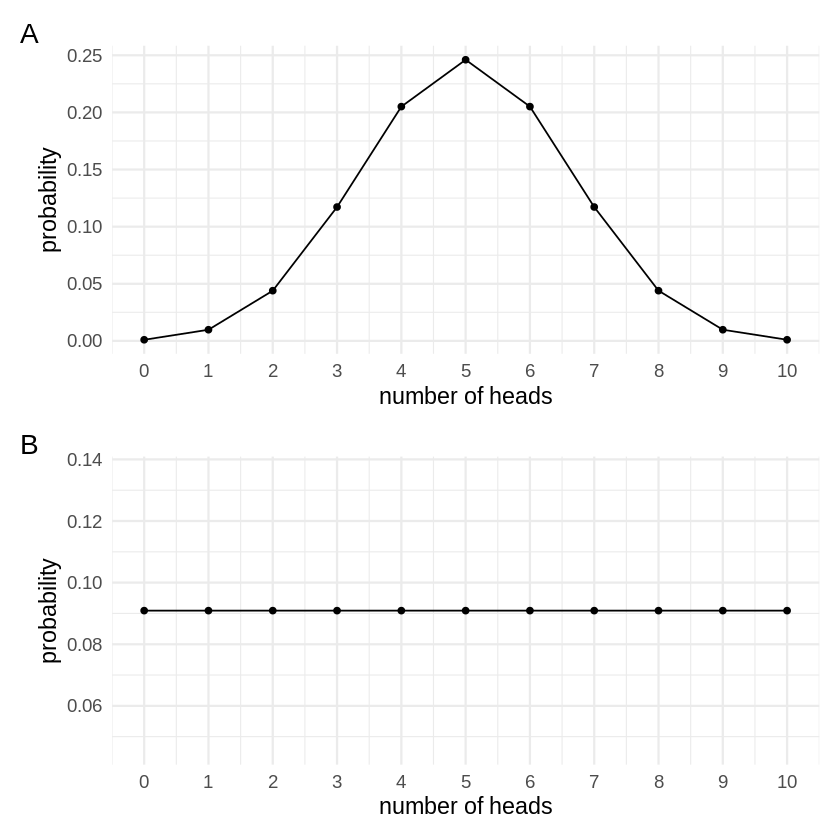

In [14]:


# the two predictions

predictions1 <- tibble(
  x = seq(0, 10, 1),
  y = dbinom(x, 10, 0.5)
) %>%
  ggplot(data = ., aes(x = x, y = y)) +
  geom_point() +
  geom_line() +
  labs(x = "number of heads", y = "probability") +
  scale_x_continuous(breaks = seq(0, 10, 1)) +
  theme_minimal(14)


predictions2 <- tibble(
  x = seq(0, 10, 1),
  y = 1 / length(x)
) %>%
  ggplot(data = ., aes(x = x, y = y)) +
  geom_point() +
  geom_line() +
  labs(x = "number of heads", y = "probability") +
  scale_x_continuous(breaks = seq(0, 10, 1)) +
  theme_minimal(14)

(predictions1  / predictions2) +
  plot_annotation(tag_levels = "A")


Now that we have a intuition for hypotheses in terms of predictions, let
use formalise it a bit. 
And instead of thinking about all the data that
might be produced let's just try and think about the probability of
obtaining our data of 8 heads in 10 flips. If a coin is fair, then in 10
coin flips there are exactly $2^{10}$ possible sequences and 45 of these
sequences would give 8 heads in 10 flips. Therefore, if the coin is fair,
then the probability of obtaining our result of 8 heads in 10 flips in
$\frac{45}{1024}$, or about 0.044. I've worked this out exactly, but we'd
get the same value if we ran the simulations, or if we just looked at the
likelihood function at $\theta=0.5$. This is after all, what the
likelihood function tells use: the probability of obtaining our data for
a given value of the parameter. 

Now on to the more complex example where the coin bias is some unknown
value between 0 and 1. What now is the probability of obtaining our data.
One good strategy of dealing with unknowns is to average across the
possibilities. For example, if I didn't know what the coin bias was, but
I knew it could either be 0.5 or 0.6, then to work out the probability of
obtaining our current data I could just work out the probability of
obtaining our current data if the bias was 0.5 (~0.044), and then work out
the probability of obtaining our current data if 0.6 (~0.121), and then
just average them together (~0.082). Again, I just take the values from
the likelihood function at $\theta=0.5$ and $\theta=0.6$ and aveage them
together. 

But in our example it's not just the case that the bias of the coin could
be 0.5 or 0.6. For our second hypothesis we said it could be any value
between 0 and 1. That is, hypothesis is the set $\Theta
= \{\theta_1,\theta_2,...,\theta_n\}$ where each $\theta_1$ to $\theta_n$
is some value between 0 and 1. To keep things simple for now, we'll say
that $\Theta =\{\theta_1=\frac{0}{10},
\theta_2=\frac{1}{10},...,\theta_{11}=\frac{10}{10}\}$. An average is just
a sum where each value is multiplied by $\frac{1}{n}$, therefore, the
average across these 11 values would be:

$$\sum_{i=1}^{11}\mathcal{L}(\theta_i|\mathbf{y})\cdot{}\frac{1}{11}$$

This gives a value of approximately $\frac{1}{12}$, which is pretty close
to the value of $\frac{1}{11}$ we worked out earlier. Why is it not the
same? Well, earlier, we said it could be **any** value between 0 and 1.
We're only looking at 11 values. Let's instead look at 101 values between
0 and 1. Now $\Theta = \{\theta_1=\frac{0}{100},
\theta_2=\frac{1}{100},...,\theta_{101}=\frac{100}{100}\}$. Now we get
a value that's even closer to $\frac{1}{11}$. To get to exactly
$\frac{1}{11}$, however, we're going to have to look at even more points.
Instead of spacing the points out by $\frac{1}{10}$ or $\frac{1}{100}$,
we're going to need infinitesimally small spacing. That's means we just
switch out the sum for an integral, but the logic is the same. We're still
just taking an average.

$$\int_{\theta\in\Theta}\mathcal{L}(\theta|\mathbf{y})d(\theta)$$

Now that we're taking an integral, we get exactly $\frac{1}{11}$.

Now that we have these two values: First, $\frac{45}{1024}$, which gives the
probability of obtaining 8 heads in 10 flips if $\theta=0.5$, and second,
$\frac{1}{11}$, which the probability of obtaining 8 head in  10 flips if
$\theta$ was some unknown value between 0 and 1, what can we do with them?
Well, we can just take the ratio! Just like we did with the two simple point
hypotheses, we can also take the ratio between our simple point hypothesis and
our more complex hypothesis. Taking this ratio tells us that's we'd be
$2\frac{34}{495}$ times more likely to see our data if $\theta$ was some
unknown value between 0 and 1 than if $\theta=0.5$.

Thinking back to the  *law of likelihood* that we covered at the start of
this section, we said if our data would be produced more often if
$\mathcal{H}_1$ were true than if $\mathcal{H}_2$ were true, then the data
provide support for $\mathcal{H}_1$ over $\mathcal{H}_2$. This is exactly
the number that we've just worked out.

### There's more than one way to average

Above we worked out two values. The second number we calculated by
averaging the likelihood function, but the first number we calculated by
just taking a single point on the likelihood function. So one involved an
average and the other did not. Or did it? We can actually think of both as
involving an average of the likelihood function. They're just different
kinds of average. We can view both as taking a *weighted average*, where
different values contribute more or less to the average. For the second
number, all values in the average were *weighted equally*. That is, it was
just like a regular average. For the first, it can be viewed as taking an
average where the likelihood value for $\theta=0.5$ is given a weight of
1, and all over values of given a weight of 0. We could visualise these
weighting in the plots below. 

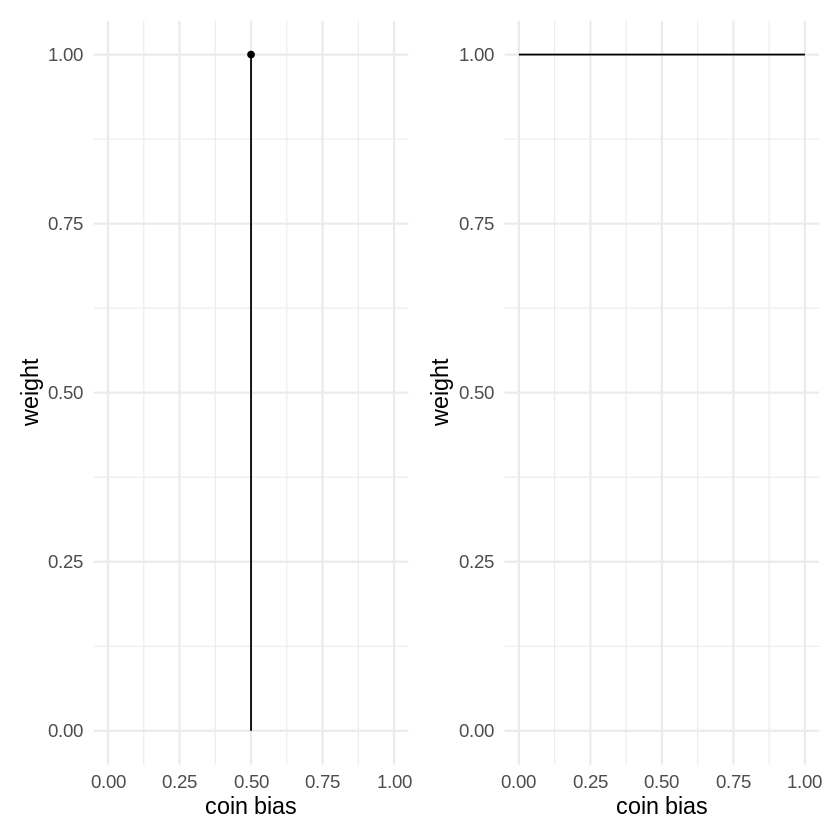

In [15]:
#| fig.height: 4

point <- ggplot(
  data = tibble(x = 0.5, y = 1),
  aes(x = x, y = y)
) +
  geom_point() +
  geom_segment(x = 0.5, xend = 0.5, y = 0, yend = 1) +
  xlim(0, 1) +
  ylim(0, 1) +
  labs(x = "coin bias", y = "weight") +
  theme_minimal(14)

uniform <- ggplot(
  data = tibble(x = seq(0, 1, 0.1), y = 1),
  aes(x = x, y = y)
) +
  geom_line() +
  xlim(0, 1) +
  ylim(0, 1) +
  labs(x = "coin bias", y = "weight") +
  theme_minimal(14)



point + uniform

These *weightings* can be thought of as *probability distributions*. We
are going to call these **priors**. Mathematically, they represents the
weights that we apply to the values that we average together. But what do
they represents *conceptually*. One way to think of them is that they
*represent our beliefs about the parameter value* (in this case the *coin
bias*). Or, that they represent our *model of the hypothesis*-that is,
they represent what the hypothesis has to say about the parameter value.
So the fair coin hypothesis represents is a model that says *the coin bias
is exactly 0.5*. The other hypothesis is a model that say *all values of
the coin bias between 0 and 1 are equally probable*. 

At the start of this section we said that for our alternative for a fair
coin we'd say that all values of the coin bias were equally likely, and
this is what we'd mean by an unfair coin. But this is only one possible
model of an unfair coin. We might actually think that if a coin is unfair
then it'll show heads far more often than tails. Or, we might think that
unfair coins will show tails more often than heads. We might even think
that unfair coins will behave very similarly to fair coins, but they'll
just outcomes of 5 head and 5 tails a little bit less often than the
$\frac{252}{1024}$ that we'd see with a perfectly fair coin. These are all
different *models* that we might have about unfair coins. We can represent
these hypotheses in terms of what they say about the coin bias parameter.
That is, we can represent them as *weights* or *priors*. We'll learn more
in the next section about how to specify these, but for now I'll just
generate some plot. 


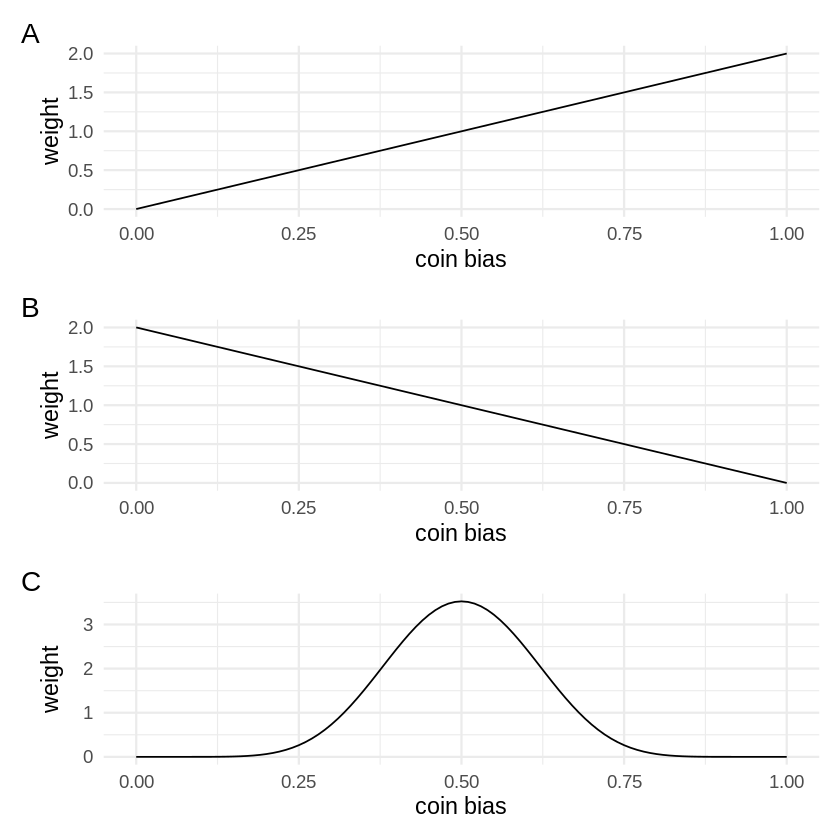

In [16]:
#| fig.height: 7

fair_coin <- plot(bayesplay::prior("point", 0.5)) +
  theme_minimal(14) +
  labs(x = "coin bias", y = "weight")

more_heads <- plot(bayesplay::prior("beta", 2, 1)) +
  theme_minimal(14) +
  labs(x = "coin bias", y = "weight")

more_tails <- plot(bayesplay::prior("beta", 1, 2)) +
  theme_minimal(14) +
  labs(x = "coin bias", y = "weight")

just_off <- plot(bayesplay::prior("beta", 10, 10)) +
  theme_minimal(14) +
  labs(x = "coin bias", y = "weight")

all_equal <- plot(bayesplay::prior("beta", 1, 1)) +
  theme_minimal(14) +
  labs(x = "coin bias", y = "weight")

(more_heads /
  more_tails /
  just_off) + plot_annotation(tag_levels = "A")

In panel **A**, values of the coin bias closer to 1 (show heads all the time)
and given more weight than values closer to 0 (never show heads). This means we
except the coin to show heads more often. In panel **B**, we see the opposite.
Finally, in panel **C**, we weight values closer to 0.5 (fair) higher than
values closer to 0 or 1. That is, we don't think the coin bias is exactly 0.5, 
but we think values closer to 0.5 are more probable than values further away
from 0.5.

Now that we're taking a weighted average, our earlier formula before:

$$\int_{\theta\in\Theta}\mathcal{L}(\theta|\mathbf{y})d(\theta)$$

Now just becomes:

$$\int_{\theta\in\Theta}\mathcal{L}(\theta|\mathbf{y})p(\theta)d\theta$$

In words we'd read this as:

> *The probability of obtaining our data under the specified model is equal to
> the integral of the likelhood (the model of the data) multiplied by the prior 
> (the weights).*

We might denote this as $p(Y|\mathcal{M}_i$) or simply $\mathcal{M}_i$. When
comparing two models---for example, $\mathcal{M}_1$ and $\mathcal{M}_0$, we
take the ratio as follows:

$$\frac{\mathcal{M}_1}{\mathcal{M}_0}$$

Try not to be too intimidated by the formula above. It just means that we're
working out the probability of obtaining our data for a given value of the
parameter, and that we're doing this for a range of parameter values. And
finally, we're taking a weighted average of these. There's only 3 parts to the
formula. 

1. The likelihood, which tells us the probability of obtained our data at
   a specific value of the parameter: $\mathcal{L}(\theta|\mathbf{y})$

2. The prior, which determines the weights for weighted average of the 
   likelihood values: $p(\theta)$

3. The integral, which performs the "averaging" across all the different values
   of the parameter range: $\int_{\theta\in\Theta}...d\theta$

#### Visualising predictions

We can also represent these different models of the coin bais in terms of what
outcomes we'd predict, just like we did with the earlier predictions. In the
next section, we'll also learn about how to turns priors into predictions, but
for now we'll just look at some plots. In each of these plots we'll show what
we would  predict if the coin was exactly fair overlaid on each of these
different models of *unfairness*. In each of the plots we'll highlight our
actual outcome of 8 heads in 10 flips.

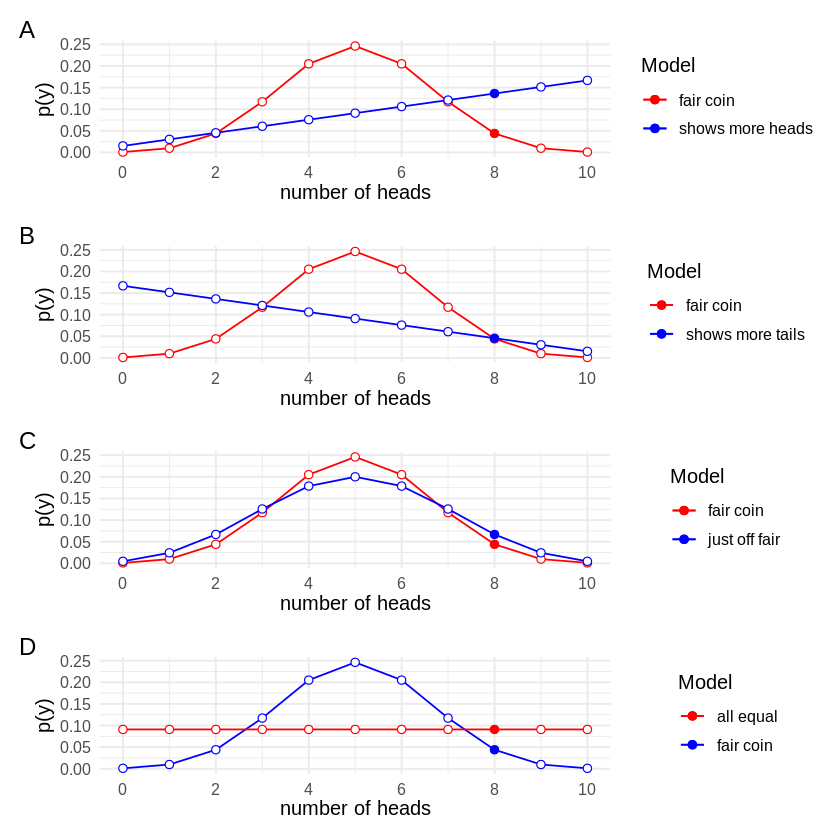

In [17]:
#| fig.height: 10

`fair coin` <- bayesplay::extract_predictions(
  bayesplay::likelihood("binomial", 8, 10) *
    bayesplay::prior("point", 0.5)
)

`shows more heads` <- bayesplay::extract_predictions(
  bayesplay::likelihood("binomial", 8, 10) *
    bayesplay::prior("beta", 2, 1)
)

`shows more tails` <- bayesplay::extract_predictions(
  bayesplay::likelihood("binomial", 8, 10) *
    bayesplay::prior("beta", 1, 2)
)

`just off fair` <- bayesplay::extract_predictions(
  bayesplay::likelihood("binomial", 8, 10) *
    bayesplay::prior("beta", 10, 10)
)

`all equal` <- bayesplay::extract_predictions(
  bayesplay::likelihood("binomial", 8, 10) *
    bayesplay::prior("beta", 1, 1)
)

((bayesplay::visual_compare(`fair coin`, `shows more heads`) +
  labs(x = "number of heads", y = "p(y)") +
  theme_minimal(12)) /
  (bayesplay::visual_compare(`fair coin`, `shows more tails`) +
    labs(x = "number of heads", y = "p(y)") +
    theme_minimal(12)) /
  (bayesplay::visual_compare(`fair coin`, `just off fair`) +
    labs(x = "number of heads", y = "p(y)") +
    theme_minimal(12)) /
  (bayesplay::visual_compare(`fair coin`, `all equal`) +
    labs(x = "number of heads", y = "p(y)") +
    theme_minimal(12))) +
  plot_annotation(tag_levels = "A")

In panel **A**, we see the predictions from our fair coin model against our
predictions from a model where the coin shows heads more often. In panel **B**,
we see the fair coin predictions against a coin that shows tails more often. In
panel **C** we see our fair coin model again a model where the bias is just
slightly off from fair. And finally in panel **D**, we see the predictions of
the fair coin model against a model where we have no reason for thinking that
one outcome is more likely than any other outcome. 

In each of these panels we can weigh up the evidence for whether our data
support one model over the other by looking at whether our data would be
produced more often if $\mathcal{H}_1$ were true than if $\mathcal{H}_2$ were
true. That is,w we can see whether the data provide support for $\mathcal{H}_1$
over $\mathcal{H}_2$ just by looking at whether the blue highlighted point is
higher (more probable) than the red highlighted point (less probable).